# Girvan Newman

In [2]:
import glob
import numpy as np
import networkx as nx
from os import listdir, chdir
from os.path import isfile, join

mypath = '../raccoon_proximity_weighted'
files = [mypath + '/' + f for f in listdir(mypath) if isfile(join(mypath, f))]
files = [(int(f.split('_')[5].split('.')[0]), f) for f in files]
files.sort()

Community 0
Community 1
Community 2
Community 3


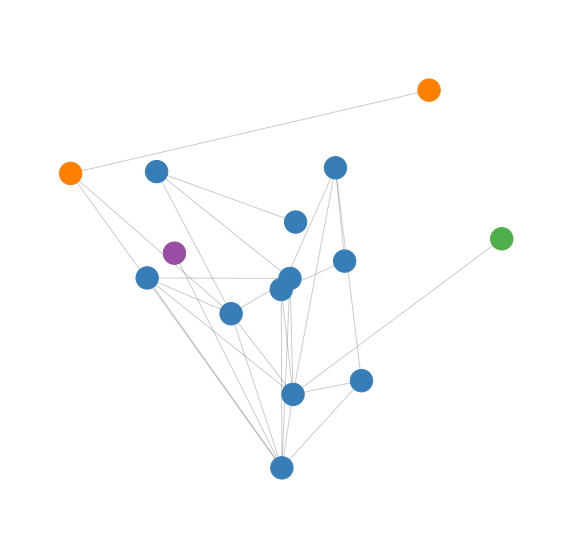

In [3]:
from networkx import edge_betweenness_centrality
from random import random
from itertools import islice
from networkx.algorithms.community.centrality import girvan_newman
import matplotlib.pyplot as plt
import pandas as pd

def most_valuable_edge(G):
    centrality = edge_betweenness_centrality(G)
    max_cent = max(centrality.values())
    # Scale the centrality values so they are between 0 and 1,
    # and add some random noise.
    centrality = {e: c / max_cent for e, c in centrality.items()}
    # Add some random noise.
    centrality = {e: c + random() for e, c in centrality.items()}
    return max(centrality, key=centrality.get)


filt = [str(x) for x in range(16)]
g = nx.read_graphml(files[0][1]).subgraph(filt)

gn_generator = girvan_newman(g, most_valuable_edge)
num_iter = 2 # Choose number of iterations
gn_communities = next(islice(gn_generator, num_iter, None))

gn_dict_communities = {}

for i, c in enumerate(gn_communities):
    print ("Community {}".format(i))
    for node in c:
        gn_dict_communities[node] = i + 1
        
for node in g:
    if node not in gn_dict_communities.keys():
        gn_dict_communities[node] = -1
        
# gn_pos = community_layout(G, gn_dict_communities) # Manually creating layout
#gn_pos = nx.spring_layout(g) #Spring layout per week
gn_pos = pd.read_csv('final_pos.csv', index_col='index')
gn_pos.index = gn_pos.index.map(str)
gn_pos = dict(gn_pos.apply(lambda x: np.array([x[0], x[1]]), axis=1))

from matplotlib import cm
gn_colors = []
for node in g.nodes:
    gn_colors.append(cm.Set1(gn_dict_communities[node]))
    
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(g, gn_pos, node_color=gn_colors, node_size=500)
nx.draw_networkx_edges(g, gn_pos, alpha=0.2)
plt.axis('off')
plt.show()

In [12]:
from networkx import edge_betweenness_centrality
from random import random
from itertools import islice
from networkx.algorithms.community.centrality import girvan_newman
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

filt = [str(x) for x in range(16)]
final_pos = pd.read_csv('final_pos.csv', index_col='index')
final_pos.index = final_pos.index.map(str)
final_pos = dict(final_pos.apply(lambda x: np.array([x[0], x[1]]), axis=1))

def mve(G):
    # assume that the graph is already filtered
    mx = 0 
    for n in G.nodes():
        for w in G[n]:
            if G[n][w]['weight']>mx:
                mx = G[n][w]['weight']
                edge = (n , w)
    return edge

def comm(g, num_iter=1):
    gn_generator = girvan_newman(g, mve)
    gn_communities = next(islice(gn_generator, num_iter, None))

    gn_dict_communities = {}

    for i, c in enumerate(gn_communities):
        for node in c:
            gn_dict_communities[node] = i + 1

    for node in g:
        if node not in gn_dict_communities.keys():
            gn_dict_communities[node] = -1

    return gn_dict_communities

In [13]:
import plotly.graph_objects as go

def create_edges(G, pos):
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')
    return edge_trace

def create_nodes(G, pos):
    node_x = [-1]
    node_y = [-1]
    for p in pos.values():
        x, y = p
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(size=20,
            line_width=2))

    node_adjacencies = [0]
    node_text = ['na']
    c = comm(G, 1)
    for k in pos.keys():
        if k in G.nodes:
            node_adjacencies.append(c[k])
            node_text.append('Community: '+str(c[k]))
        else:
            node_adjacencies.append(0)
            node_text.append('Community: NA')

    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text
    return node_trace

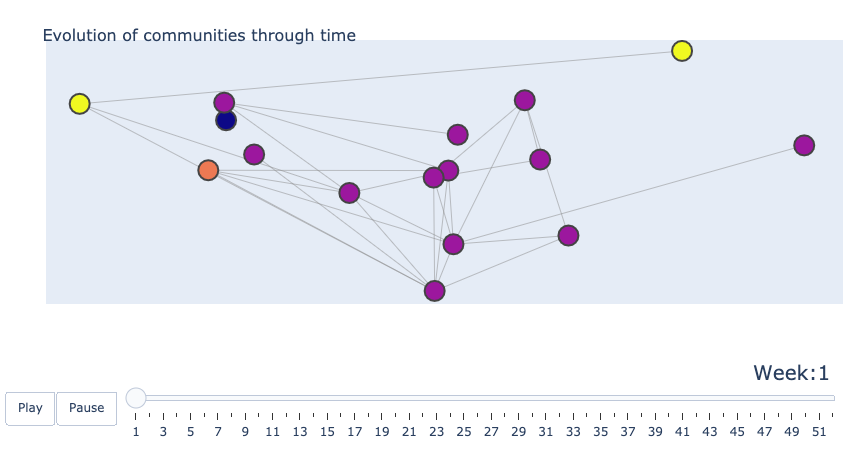

In [14]:
weeks = list(range(1, 53))
x = [xx[0] for xx in final_pos.values()]
y = [xx[1] for xx in final_pos.values()]
# make figure
G = nx.read_graphml(files[0][1]).subgraph(filt)
fig_dict = {
    "data": [create_edges(G, final_pos), create_nodes(G, final_pos)],
    "layout": {},
    "frames": []
}

# fill in most of layout
fig_dict["layout"]['title'] = '<br>Evolution of communities through time'
fig_dict["layout"]['titlefont_size'] = 16
fig_dict["layout"]['showlegend'] = False
fig_dict["layout"]['hovermode'] = 'closest'
fig_dict["layout"]['margin'] = dict(b=20,l=5,r=5,t=40)
fig_dict["layout"]['xaxis'] = dict(showgrid=False, zeroline=False, showticklabels=False,
                                   range=[min(x)*1.1, max(x)*1.1])
fig_dict["layout"]['yaxis'] = dict(showgrid=False, zeroline=False, showticklabels=False,
                                   range=[min(y)*1.1, max(y)*1.1])

fig_dict["layout"]["sliders"] = {
    "args": [
        "transition", {
            "duration": 400,
            "easing": "cubic-in-out"
        }
    ],
    "initialValue": "1",
    "plotlycommand": "animate",
    "values": weeks,
    "visible": True
}
fig_dict["layout"]["updatemenus"] = [
    {
        "buttons": [
            {
                "args": [None, {"frame": {"duration": 1000, "redraw": False},
                                "fromcurrent": True, "transition": {"duration": 300,
                                                                    "easing": "quadratic-in-out"}}],
                "label": "Play",
                "method": "animate"
            },
            {
                "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                  "mode": "immediate",
                                  "transition": {"duration": 0}}],
                "label": "Pause",
                "method": "animate"
            }
        ],
        "direction": "left",
        "pad": {"r": 10, "t": 87},
        "showactive": False,
        "type": "buttons",
        "x": 0.1,
        "xanchor": "right",
        "y": 0,
        "yanchor": "top"
    }
]

sliders_dict = {
    "active": 0,
    "yanchor": "top",
    "xanchor": "left",
    "currentvalue": {
        "font": {"size": 20},
        "prefix": "Week:",
        "visible": True,
        "xanchor": "right"
    },
    "transition": {"duration": 300, "easing": "cubic-in-out"},
    "pad": {"b": 10, "t": 50},
    "len": 0.9,
    "x": 0.1,
    "y": 0,
    "steps": []
}

#Update the data and frames

for f in files:
    G = nx.read_graphml(f[1]).subgraph(filt)
    frame = {"data": [create_edges(G, final_pos), create_nodes(G, final_pos)], "name": f[0]}
    fig_dict["frames"].append(frame)
    slider_step = {"args": [
        [f[0]],
        {"frame": {"duration": 300, "redraw": False},
         "mode": "immediate",
         "transition": {"duration": 300}}
    ],
        "label": f[0],
        "method": "animate"}
    sliders_dict["steps"].append(slider_step)
    
fig_dict["layout"]["sliders"] = [sliders_dict]

fig = go.Figure(fig_dict)

fig.show()

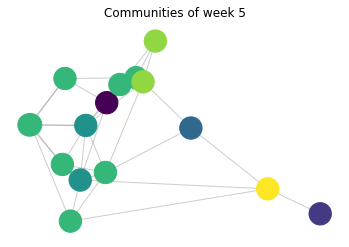

In [15]:
G = nx.read_graphml(files[4][1]).subgraph(filt)
p = pd.read_csv('pos_w5.csv', index_col=0)
p.index = p.index.map(str)
p = dict(p.apply(lambda x: np.array([x[0], x[1]]), axis=1))
nx.draw_networkx_nodes(G, p, node_color=list(comm(G, 5).values()), node_size=500, label=G.nodes())
nx.draw_networkx_edges(G, p, alpha=0.2)
plt.axis('off')
plt.title('Communities of week 5')
plt.show()